# GEOS 518: Jupyter Notebook Assignment #2: Auto Regressive Models

## Taylor Dudunake
Due: 3/12/18

** In this Jupyter Notebook, I will complete the following tasks for discharge data at Middle Fork Boise River near Twin Springs (USGS 13184500): **
1. Read in dataset and perform any additional pre-processing needed
2. Split dataset into a "training" dataset used to estimate the parameters of the AR model, and a "test" dataset against which I will test the model
3. Estimate the parameters of an AR(1) model using the training dataset
    * Compute the autocorrelation function
    * Use the YW Equations to estimate the AR(1) parameters
    * Use the statsmodel AR tools to estimate the parameters based on the dataset
    * Compare the YW parameters to those from the statsmodel library
4. Estimate the parameters of an AR(2) model using the training dataset
    * Use the YW equations to estimate the AR(2) parameters
    * Use the statsmodel AR tools to estimate the parameters based on the dataset
    * Compare the YW parameters to those from the statsmodel library
5. Apply the AR(1) and AR(2) models to the "test" dataset (the one withheld from parameter estimation)
6. Plot the modeled time series for the AR(1) and AR(2) models against the observed time series for comparison
7. Comment on key differences and distinctions between the models themselves and the extent to which they reproduce the observations

## Preliminary Tasks: loading libraries
This cell imports necessary libraries to perform tasks in this Jupyter Notebook. The stats model is especially important when estimating the AR(1) and AR(2) parameters.

In [3]:
import pandas as pd # Required for data management tasks

import numpy as np # Required for computation tasks useful for this analysis

import matplotlib.pyplot as plt # Required for all things plotting

from pandas.plotting import autocorrelation_plot # Generates an autocorrelation plot

import statsmodels.tsa.api as sm # Required for ADF Test

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Task 1. Read in dataset and perform any additional pre-processing needed
These cells import discharge data from .pkl file previously generated. It's important to view and inspect the data to ensure everything is properly formatted. In this case, the dates are properly formatted in the heading "SerDates". For the following tasks, I also need to describe each data entry by its water year which can be seen in the second block of code.

In [4]:
# Load the MF Boise discharge dataset
df = pd.read_pickle('MFBoiseDischarge_WY2001-2017.pkl')
Q = df['Q (cms)'].values # sets discharge data in dataframe to a variable
day_num = np.arange(0,np.size(Q),1)

In [5]:
# These lines of code assign a water year for each point in the time series.
WY = np.zeros(len(df['Y'].index))
WY[df['M'].values < 10] = df['Y'].values[df['M'].values < 10]
WY[df['M'].values >= 10] = df['Y'].values[df['M'].values >= 10] + 1
df['WY'] = WY.astype(int)

qrows = np.concatenate([np.arange(0,10,1),np.arange(-11,-1,1)])
df.iloc[qrows,:]

,Y,M,D,Q (cms),SerDates,WY
0,2000,10,1,8.694,2000-10-01,2001
1,2000,10,2,9.062,2000-10-02,2001
2,2000,10,3,8.807,2000-10-03,2001
3,2000,10,4,8.779,2000-10-04,2001
4,2000,10,5,8.750,2000-10-05,2001
5,2000,10,6,8.779,2000-10-06,2001
6,2000,10,7,8.779,2000-10-07,2001
7,2000,10,8,8.722,2000-10-08,2001
8,2000,10,9,8.665,2000-10-09,2001
9,2000,10,10,8.835,2000-10-10,2001


## Task 2. Split the dataframe into a training and test portion
This block of code splits the time series data into a training and test portion of dataset. The training dataset is used to estimate the parameters of the AR models. The test dataset is used to test the AR models against which can then be seen in task 5 and 6.

In [6]:
# I segment the whole dataframe into a training dataset (everything that's not Water Year 2015) and a test dataset (everything that is Water Year 2015).
df_train = df[df.WY != 2015]
df_test  = df[df.WY == 2015]

# Sets discharge data in dataframe to a variable
Qtrain = df_train['Q (cms)'].values 
Qtest = df_test['Q (cms)'].values

## Task 3. Estimate the parameters of an AR(1) model using the training dataset

### Task 3.1. Compute the autocorrelation function
These cells calculate the autocorrelation function and partial autocorrelation function of the training dataset. Initially, I use the pandas plotting library to display the autocorrelation function up to lag 6209. I then calculate the autocorrelation using a different method then view the first 40 lags. This allows me to extract the autocorrelation coefficients used in task 3.2 and 4.1.

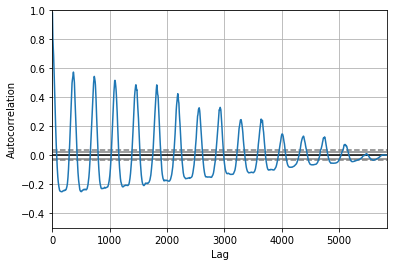

In [7]:
# This function calculates the autocorrelation coeffecient for lag = 0-6209
autocorrelation_plot(Qtrain) 
plt.ylim(-0.5,1.0)
plt.show()

In [8]:
# This for loop calculates the autocorrelation coeffecient for lag = 0-40 of the training data
Nk = 40
K  = np.arange(0,Nk,1)
Rk = np.zeros((Nk,1))

for k in K:
    Qt   = Qtrain[k:-1] 
    Qtmk = Qtrain[0:-(1+k)]
    R = np.corrcoef(Qtmk,Qt)
    Rk[k] = R[1,0]

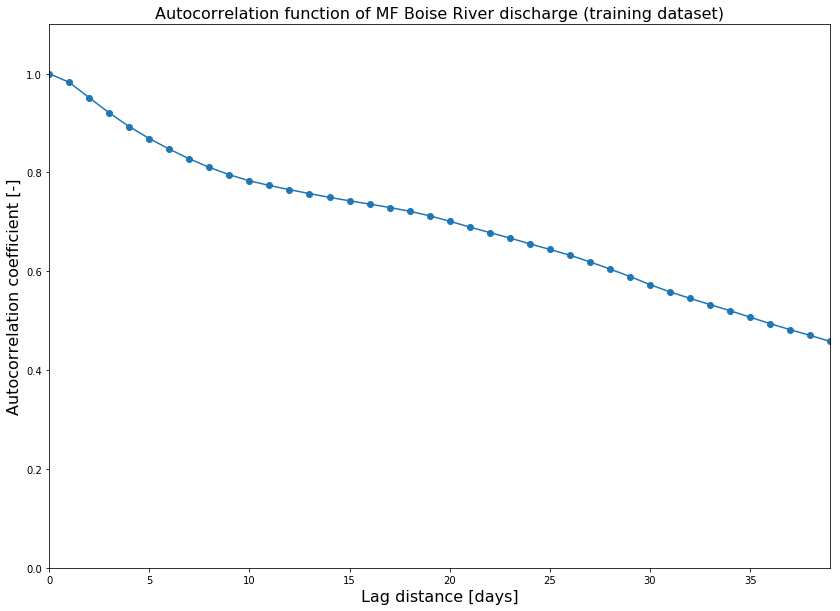

In [9]:
# The following lines of code plot the above autocorrelation function
plt.figure(figsize=(14,10))
plt.plot(K,Rk,'o-')
plt.xlim(0.0,np.amax(K.astype(float)))
plt.ylim(0.0,1.1)
plt.title('Autocorrelation function of MF Boise River discharge (training dataset)',fontsize=16)
plt.xlabel('Lag distance [days]',fontsize=16)
plt.ylabel('Autocorrelation coefficient [-]',fontsize=16)
plt.show()

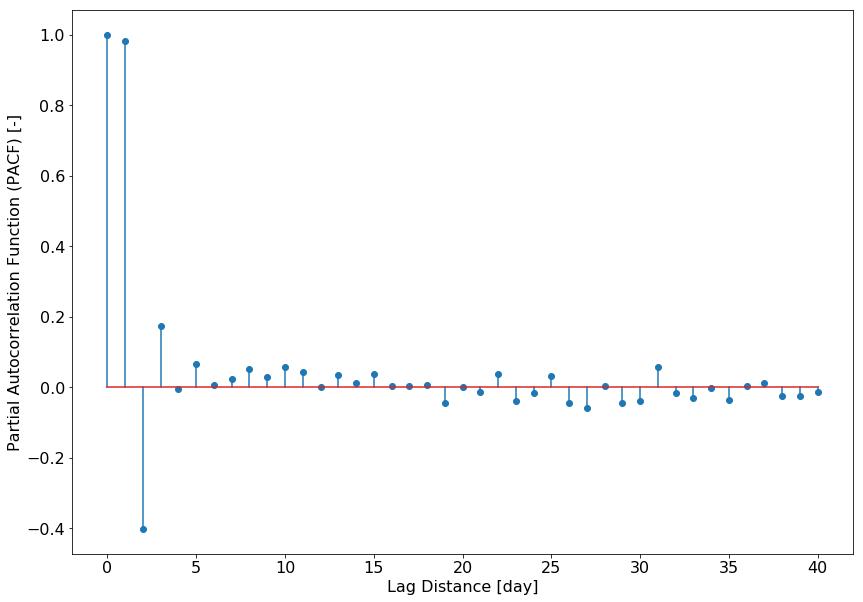

In [10]:
# This section of code uses the statsmodel library to plot the PACF of the training dataset
Qpacf = sm.pacf(Qtrain)

plt.figure(figsize=(14,10))
plt.stem(Qpacf)
plt.ylabel('Partial Autocorrelation Function (PACF) [-]',fontsize=16)
plt.xlabel('Lag Distance [day]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

### Task 3.2. Use Yule-Walker equations to estimate the AR(1) parameters
This cell calculates the parameters using the assumption that a good estimate for the AR(1) parameter (phi1) would be rho1, which is the lag 1 autocorrelation coefficient.

In [11]:
# Estimating the AR(1) parameter (phi1) using the lag 1 autocorrelation coefficient
phi1 = Rk[1]
print('The AR(1) parameter is:',phi1)

The AR(1) parameter is: [ 0.98249308]


### Task 3.3. Use the statsmodel AR tools to estimate the parameters based on the dataset
This cell calculates the parameters using the statsmodel library, an alternative method to what was done in task 3.2.

In [12]:
# Using the statsmodels library to estimate the parameters of the AR(1) model.
Q_AR1_model = sm.AR(Qtrain).fit(1)
AR1_mu = Q_AR1_model.params[0]
AR1_phi1 = Q_AR1_model.params[1]
print('The statsmodel library calculated the parameter to be', AR1_phi1,'. Also, the mu value is', AR1_mu)

The statsmodel library calculated the parameter to be 0.982482380335 . Also, the mu value is 0.59051767824


### Task 3.4. Compare the YW parameters to those from the statsmodel library

Despite using two different methods for parameter estimation, they yield values that are within 0.00001 of eachother. Through this comparison, I believe that both methods may be acceptable for parameter estimation of an AR(1) model.

## Task 4. Estimate the parameters of an AR(2) model using the training dataset

### Task 4.1. Use Yule-Walker equations to estimate the AR(2) parameters

In [13]:
# Estimate the parameters of the AR(2) model using the autocorrelation coefficients (Rho 1 and 2) for lag 1 and 2
AR2_phi1 = (1-(((Rk[1]**2)-Rk[2])/((Rk[1]**2)-1))*Rk[1])
AR2_phi2 = (((Rk[1]**2)-Rk[2])/((Rk[1]**2)-1))
print('Using the YW Equations, the AR(2) parameters are calculated to be:', AR2_phi1, 'and', AR2_phi2)

Using the YW Equations, the AR(2) parameters are calculated to be: [ 1.39317876] and [-0.40018476]


### Task 4.2. Use the statsmodel AR tools to estimate the parameters based on the dataset

In [14]:
# Using the statsmodels library to estimate the parameters of the AR(2) model.
Q_AR2_model = sm.AR(Qtrain).fit(2)
AR2_mu = Q_AR2_model.params[0]
AR2_phi1 = Q_AR2_model.params[1]
AR2_phi2 = Q_AR2_model.params[2]
print('The statsmodel library calculated the parameters to be', AR2_phi1, 'and', AR2_phi2,'. Also, the mu value is', AR2_mu)

The statsmodel library calculated the parameters to be 1.37559271134 and -0.400110904379 . Also, the mu value is 0.825856568113


### Task 4.3. Compare the YW parameters to those from the statsmodel library

The two methods used for parameter estimation of an AR(2) model also result in similar estimates but as clas as the estimated parameters of the AR(1) model. See task 4.1 and 4.2 for these estimates.

## Task 5 & 6. Apply the AR(1) and AR(2) models to the "test" dataset and plot the modeled time series for the AR(1) and AR(2) models against the observed time series for comparison

These blocks then plot the modeled data from the AR(1) and AR(2) model againt the test data. This gives us a good visual inspection of how well the models compare to real data. The second cell calculates quantitative values of how the models compare and then plots the modeled discharge to observed discharge of AR(1) and AR(2) models.

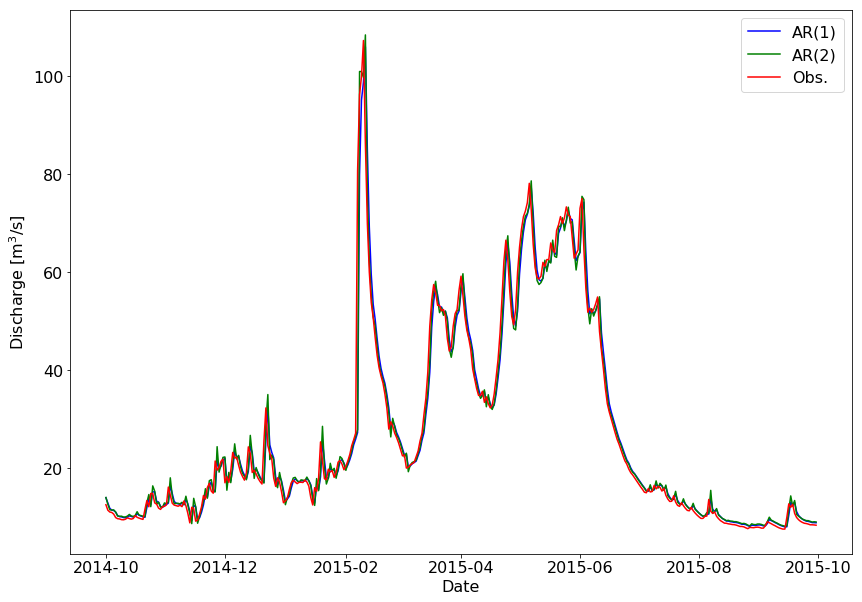

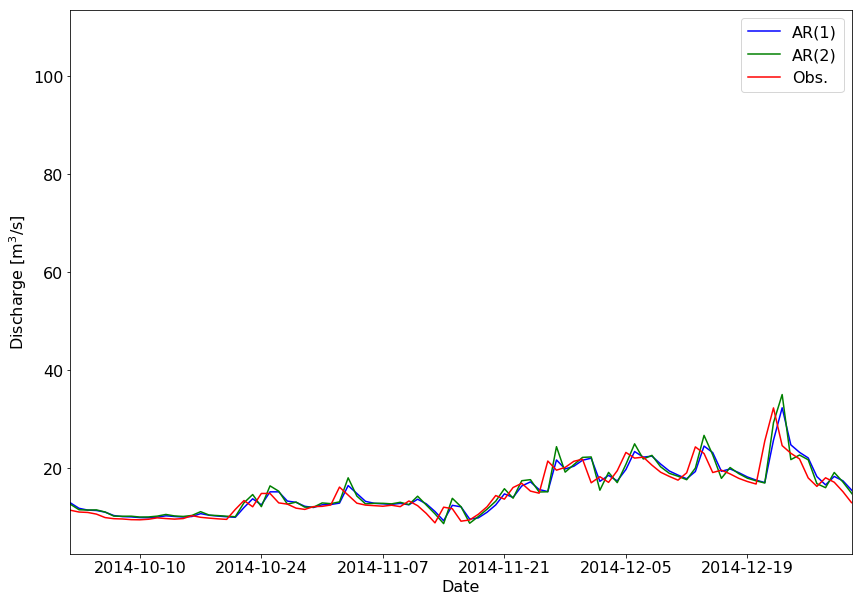

In [15]:
DatesTest = df_test['SerDates'].values

Qttm1 = np.concatenate([Qtrain[-2:-1],Qtest[0:-1]])
Qttm2 = np.concatenate([Qtrain[-3:-1],Qtest[0:-2]])

QhatAR1 = AR1_mu + AR1_phi1*Qttm1
QhatAR2 = AR2_mu + AR2_phi1*Qttm1 + AR2_phi2*Qttm2

plt.figure(figsize=(14,10))
plt.plot(DatesTest,QhatAR1,'b-')
plt.plot(DatesTest,QhatAR2,'g-')
plt.plot(DatesTest,Qtest,'r-')
plt.ylabel('Discharge [m${}^3$/s]',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('AR(1)','AR(2)','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

plt.figure(figsize=(14,10))
plt.plot(DatesTest,QhatAR1,'b-')
plt.plot(DatesTest,QhatAR2,'g-')
plt.plot(DatesTest,Qtest,'r-')
plt.xlim([DatesTest[1],DatesTest[91]])
plt.ylabel('Discharge [m${}^3$/s]',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('AR(1)','AR(2)','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

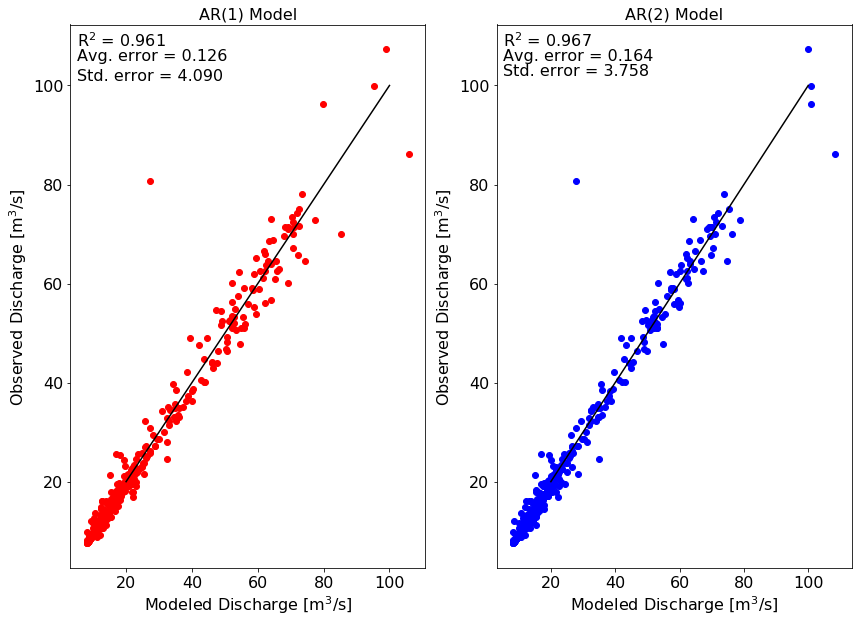

In [16]:
# Compute the R^2 values for each prediction 
R2AR1  = np.corrcoef(QhatAR1,Qtest)**2
R2AR2  = np.corrcoef(QhatAR2,Qtest)**2
muAR1  = np.mean(QhatAR1-Qtest)
stdAR1 = np.std(QhatAR1-Qtest)
muAR2  = np.mean(QhatAR2-Qtest)
stdAR2 = np.std(QhatAR2-Qtest)

# Plot the AR(1) and AR(2) model results 
plt.figure(figsize=(14,10))
plt.subplot(121)
plt.plot(QhatAR1,Qtest,'ro')
plt.title('AR(1) Model',fontsize=16)
plt.ylabel('Observed Discharge [m${}^3$/s]',fontsize=16)
plt.xlabel('Modeled Discharge [m${}^3$/s]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2AR1[0,1], xy=(5,108), fontsize=16)
ax.annotate('Avg. error = %.3f'%muAR1, xy=(5,105), fontsize=16)
ax.annotate('Std. error = %.3f'%stdAR1, xy=(5,101), fontsize=16)
plt.plot([20, 100], [20, 100], 'k-')
plt.subplot(122)
plt.plot(QhatAR2,Qtest,'bo')
plt.plot([20, 100], [20, 100], 'k-')
plt.title('AR(2) Model',fontsize=16)
plt.ylabel('Observed Discharge [m${}^3$/s]',fontsize=16)
plt.xlabel('Modeled Discharge [m${}^3$/s]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2AR2[0,1], xy=(5,108), fontsize=16)
ax.annotate('Avg. error = %.3f'%muAR2, xy=(5,105), fontsize=16)
ax.annotate('Std. error = %.3f'%stdAR2, xy=(5,102), fontsize=16)

plt.show()

## Task 5. Comment on key differences and distinctions between the models themselves and the extent to which they reproduce the observations

The R^2, average of the error, and standard deviation of the error of the AR(1) model are 0.961, 0.126, and 4.090, respectively. Also, the R^2, average of the error, and standard deviation of the error of the AR(2) model are 0.967, 0.164, and 3.758, respectively. It seems as if the data is more spread out in the AR(1) model while the data is more confined. When comparing the modeled data to the observed data, it seems that the modeled data peaks higher and slightly lagged from the observed data. Generally, though, the modeled data reproduces the observed data very well. 